# Flattening the Curve



In [53]:
from scipy.integrate import odeint
from scipy.integrate import ode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
%matplotlib inline

In [54]:
def dSIR_dt(y, t, alpha, beta):
    """
    y[0] = # of susceptible
    y[1] = # of infected
    y[2] = # of recovered
    alpha = transmission rate
    beta = recovery rate
    """
    dS = -alpha*y[0]*y[1] 
    dI = alpha*y[0]*y[1] - beta*y[1]
    dR = beta * y[1]
    return [dS, dI, dR]

In [55]:
def get_SIR(start_infected=0.001, alpha=0.8, beta=0.1, dt=0.1, t_end=80):
    """
    function for integrating a single simulation run
    """
    # set and store initial conditions
    y0 = [1-start_infected, start_infected, 0]
    t0 = 0
    t = np.arange(0, t_end, dt) 

    # initialize ode solver
    solution = odeint(dSIR_dt,y0,t,args=(alpha, beta,))
    
    plt.plot(t, solution[:, 0], label='S');
    plt.plot(t, solution[:, 1], label='I');
    plt.plot(t, solution[:, 2], label='R');
    plt.legend();
    plt.xlabel('time'); 

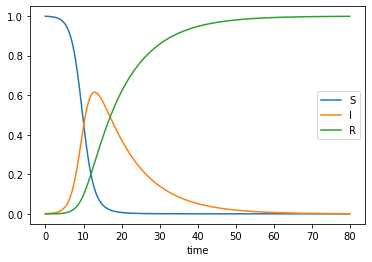

In [56]:
get_SIR()

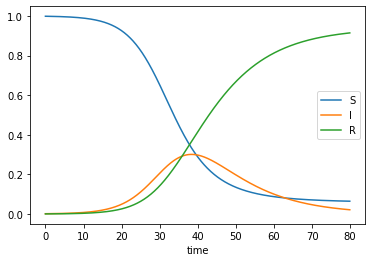

In [57]:
get_SIR(alpha=0.3)

# Two City Model

Recall from the PDF we ended up with this as our simplified two city model:
    

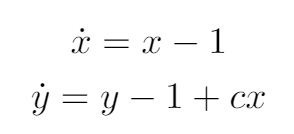

Now just translating that system into Python:

In [74]:
def dy_dt(pops, t, c, tQ):
    """
    dimensionless form of early phase of outbreak model
    computes change in number of infected for two populations, w and c
    c = initial rate at which infected move from w to c
    tQ = time when the c is set to 0 (when flights are stopped)
    """
    p = c if t < tQ else 0

    # note that there is no (-p*pops[0]), explained in the PDF
    # long story short, we don't account for number of infected leaving China
    dx = pops[0] - 1
    dy = pops[1] - 1 + p*pops[0]
    
    # didn't mention this in the PDF that much, but
    # in a program, we have to ensure that x, y 
    # never become negative
    if dx < 0 and pops[0] <= 0:
        dx = 0    
    if dy < 0 and pops[1] <= 0:
        dy = 0
    return [dx, dy]

In [80]:
def get_2Cities(c,C,tQ=math.inf,dt=0.1,t_end=10, plot_C = False, plot_A = False):
    """
    function for integrating a single simulation run
    tQ defaults to quarantine after "infinite" time, or basically never
    """
    # set and store initial conditions
    pop0 = [C, 0]
    t0 = 0
    t = np.linspace(0,t_end, int(t_end/dt))

    # initialize ode solver
    solution = odeint(dy_dt,pop0, t,args=(c, tQ,))
    
    if plot_C:
        plt.plot(t, solution[:, 0], label='China');
    if plot_A:
        plt.plot(t, solution[:, 1], label='America');
    
    if plot_C or plot_A:
        plt.legend();
        plt.xlabel('time');
    
    return solution


In [76]:
def plot_solution(solution, plot_C = True, plot_A = True, dt=0.1,t_end=10):
    # t = np.arange(0, t_end, dt) 
    t = np.linspace(0,t_end, int(t_end/dt))
    if plot_C:
        plt.plot(t, solution[:, 0], label='China');
    if plot_A:
        plt.plot(t, solution[:, 1], label='America');
    plt.legend();
    plt.xlabel('time');

So we default to c=0.05 being small as explained in the PDF. If we let C=2>1 be above the critical outbreak population of 1, and we let the quarantine never start, no matter what, outbreak will occur in both countries.

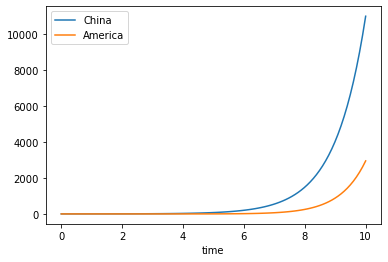

In [81]:
oof = get_2Cities(c=0.05, C=1.5, plot_A=True, plot_C=True)

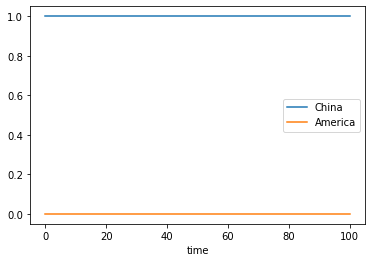

In [86]:
oof = get_2Cities(c=0.05, C=1, plot_A=True, plot_C=True, t_end=100)

As you can see, China and America reach outbreak status in tandem, just a little delayed from America since it starts from a bit behind.

# Can an Outbreak be stopped if you react quick enough?

So we have already seen that if you never quarantine, you are most definitely doomed. However, maybe there is a nonzero amount of time we can shut down the flights at such that the infected population in America doesn't grow too fast, and quarantine is able to handle

Note, I'll only be plotting America's infected population, we already know China's population will outbreak with our setup.

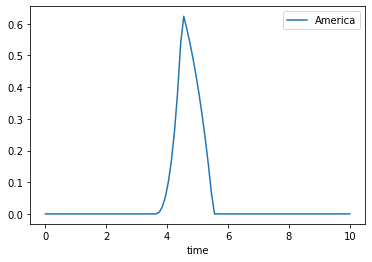

In [62]:
solution = get_2Cities(c=0.05,C=1.5,tQ=4.5)
plot_solution(solution, plot_C=False)

As you can see, with time to quarantine set at 4.5, the number of infected reaches a peak, but the peak is low enough (has to be below 1 as discussed earlier) so that the virus, countered by quarantining, is not self-sustaining, and the remains are exponentially stamped out.

However, if we are not fast enough, setting `tQ =4.7 `,

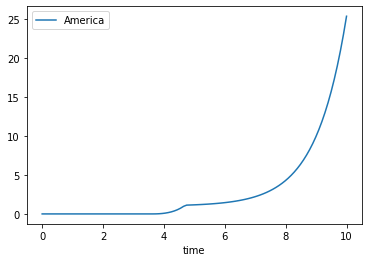

In [63]:
solution = get_2Cities(c=0.05, C=1.5, tQ=4.7)
plot_solution(solution, plot_C=False)

we can see that even though the spread temporarily slows at around 4.7, it did not slow enough (kept under a value of 1) to be completely treated, and an outbreak occurred.

So of course, as a math person, I was interested in trying to calculate how it would take (the largest `tQ` value) for outbreak to become inevitable.

## Estimating Time till Quarantine is Overwhelmed

As I mentioned in the PDF, we actually need to first calculate `t_start`, which is what I call the amount of time when quaratine started to get overwhelmed with the number of infected people coming in and people/governments start having to seriously think about the economic consequences of shutting down travel.

So how can we calculate how long this takes time? I talked about it a lot more in the PDF but long story short, we just have to realize that our real-world definition of `t_start` is equal to when the infected population of America first starts to grow, or becomes non zero. Because we can mess around with different values of our main spreading parameter `c` and the initial infected population in China `C` and get simulated simulated spread for selected values, we can then check if our derived formula matches up under different conditions.

Luckily, we have a really easy way of doing this with the tools here: since our simulation is returned as a numpy array, we can just use `np.argmax` to find the first index of our solution (which is just an array with all number of infected people at 0.01 time steps) which is larger than 0.

In [64]:
solution = get_2Cities(c=0.05, C=1.5, tQ=4.7)
np.argmax(solution[:,1]>0)/100 # divide by 100 because the nth entry it at time t=n/100

0.37

Now we can try this with many different values and plot them.

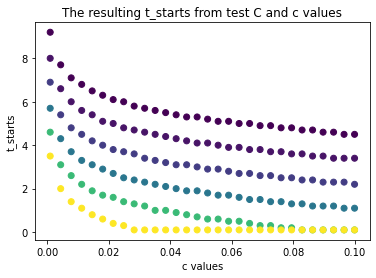

In [65]:
# Experimenting with how c and C affect t_start
Cs = np.logspace(-1,1.5,6) + 1
cs = np.linspace(0.001,0.1,30)
t_starts = []
graphing_cs = []
graphing_Cs = []
for C in Cs:
    for c in cs:
        solution = get_2Cities(c, C)
        t_starts.append(np.argmax(solution[:,1]>0)/10 if np.argmax(solution[:,1]>0) != 0 else math.nan)
        graphing_cs.append(c)
        graphing_Cs.append(C)

        
plt.xlabel("c values")
plt.ylabel("t_starts")
plt.title("The resulting t_starts from test C and c values")
plt.scatter(graphing_cs,t_starts, c=list(graphing_Cs),norm=LogNorm())

So what's going on with this kind of pretty graph? 

Well we first generated a bunch of test `Cs` and `cs`, and calculated the estimated Outbreak time with those parameters. And so the prettiness actually has some cool meaning: all points with the same color correspond with the same `C` value, brighter colors representing higher values. Notice they actually all have a similar shapes. For a fixed `C` value (along a single colored curve), increasing `c` make outbreak come much quicker, which makes sense as we have established `c` is the main spreading parameter.

And along a vertical line (holding `c` constant), dropping `C`, the initial infected population in China, delays the start of outbreak because 

Text(0, 0.5, 't+ measured')

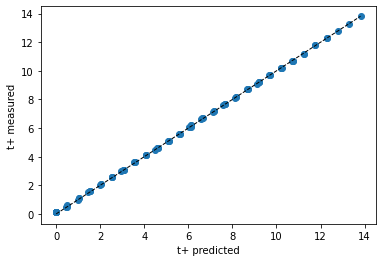

In [66]:
t_starts = []
t_starts_pred = []
for ep in np.logspace(-3,3,10):
    for rho in np.logspace(-3,-1,10):
        df = get_2Cities(rho,ep+1, t_end=20)
        
        # the "experimental" value
        ts = np.argmax(df[:,1]>0)/10 if np.argmax(solution[:,1]>0) != 0 else math.nan
        # our prediction using our formula from the PDF
        ts_pred = max(np.log(1-rho)-np.log(rho)-np.log(ep),0)
        
        t_starts.append(ts)
        t_starts_pred.append(ts_pred)
plt.plot([min(t_starts_pred),max(t_starts_pred)],[min(t_starts_pred),max(t_starts_pred)],linewidth=1,color='black',linestyle='--')
plt.scatter(t_starts_pred, t_starts)
plt.xlabel('t+ predicted')
plt.ylabel('t+ measured')

So what's this graph telling us. Well, I'll first point out that the solid line is sort of like your $y=x$ identity line that just tells us when the $x$ value is the same as the $y$ value. But the $x$ and $y$ values are nothing more than the prediction and "experimental" values for `t_start` (experimental as in the value we found through simulating the model). Therefore, it's a really good thing that the scatter plot fall so nicely on the $y=x$ line, because it means our prediction through the derived formula matches with what happens in the actual model. 



## How Long do you have after an Outbreak?

Now that we've "experimentally" verified a formula for `t_start` outbreak time, we can get a better idea of how quickly you'd need to react after (how much time after `t_start`) you have until shutting down travel?

We already saw `get_2Cities(c=0.05, C=1.5, tQ=4.5)` was fast enough, but `get_2Cities(c=0.05, C=1.5, tQ=4.7)` was too late. So let's just try probing around that area.

I'll also put a vertical line right at our predicted value of `t_start` so can easily see the difference between the outbreak and shutdown.

(3.5, 7.0)

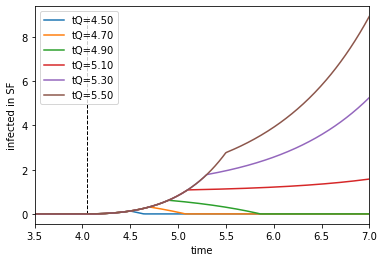

In [67]:
ax = plt.gca()
p = 0.055
e = 1.3
t_end = 7
dt = 0.01
t = np.linspace(0,t_end, int(t_end/dt))

for tQ in np.linspace(4.5,5.5,6):
    solution = get_2Cities(p,e,dt=dt,tQ=tQ,t_end=t_end)
    plt.plot(t,solution[:,1],label=f'tQ={tQ:.2f}')
    
tplus_pred = np.log(1-p)-np.log(p)-np.log(e-1)
plt.vlines(tplus_pred,ymin=0,ymax=np.max(solution[:,1]),linestyle='--',linewidth=1)
plt.ylabel('infected in SF')
plt.xlabel('time')
plt.legend()
plt.xlim([3.5,t_end])

So once the infection arrives, not all hope is lost! It seems like the latest time to wait was `tQ=4.90` if you wanted to outbreak to be controllable and the infected population to drop back to 0. However, by `tQ=5.10`, you can see that the growth does slow down a good amount, but not enough to cause the population to decay.

## Time of no return

Now for the final piece. For lack of a better name, I called the time when outbreak containment was futile the time of no return. Again, you'll have to read the PDF if you want the details, but we made some estimations for this time, which was
$$\tau_{NR} \approx \begin{cases} 0.7*\tau_{start} & c(C-1) < 1 \\ \frac{1}{cC-1} & c(C-1) >1  \end{cases} $$

(0.7706624273064591, 3.159715951956482)

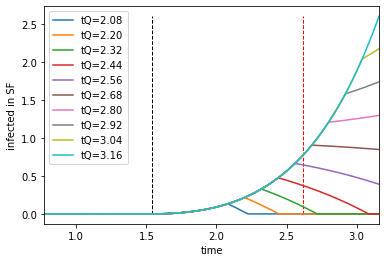

In [68]:
fig = plt.figure()
ax = plt.gca()
p = np.exp(-1)
e = np.exp(-1)+1
dt = 0.01

tplus_pred = np.log(1-p)-np.log(p)-np.log(e-1)
tC_pred = 0.7*tplus_pred if (e-1)*p < 1 else 1/(p*e-1)

t_end=tplus_pred+1.5*tC_pred
t = np.linspace(0,t_end, int(t_end/dt))

for tQ in np.linspace(tplus_pred+tC_pred/2,tplus_pred+1.5*tC_pred,10):
    solution = get_2Cities(p,e,dt=dt,tQ=tQ,t_end=t_end)
    plt.plot(t,solution[:,1],label=f'tQ={tQ:.2f}')
plt.vlines(tplus_pred,ymin=0,ymax=np.max(solution[:,1]),linestyle='--',linewidth=1)
plt.vlines(tplus_pred+tC_pred,ymin=0,ymax=np.max(solution[:,1]),linestyle='--',linewidth=1,color='red')

plt.ylabel('infected in SF')
plt.xlabel('time')
plt.legend()
plt.xlim([tplus_pred/2,tplus_pred+1.5*tC_pred])

Again we have a good plot that confirms our approximation. You can tell approximately what `tQ` is from when it deviates from the "main" curve as all the parameters remain the same till then. And so we can see that every simulation that closed down before the dashed red line started decaying to 0 infected population, while every simulation that was shut down past the red line was indeed too late and the infected population kept sustaining itself.

In [98]:
Cs = []
cs = []
tXs = []
tX_preds = []
tplus_preds= []
Y_s = np.logspace(-10,0,20)
X_s = [10**i+1 for i in range(-6,3)] # numbers from 10^-6+1 to 10^3+1, but remove 1 because that's
                                               # kind of like a critical point where t_start would blow up
for C in X_s:
    for c in Y_s:
        tplus_pred = np.log(1-c)-np.log(c)-np.log(C-1)
        tplus_pred = tplus_pred if tplus_pred > 0 else 0.1
        tC_pred = 0.7*tplus_pred if (C-1)*c < 1 else 1/(c*C-1)
        t_end = (tplus_pred+tC_pred)*10
        while True:
            solution = get_2Cities(c,C,dt=0.1,t_end=t_end)
            tX = np.argmax(solution[:,1]>1)
            if tX > 0:
                tXs.append(tX/10)
                tplus_preds.append(tplus_pred)
                tX_preds.append(tplus_pred+tC_pred)
                Cs.append(C)
                cs.append(c)
                break
            else:
                t_end = t_end*10

<ipython-input-98-e06b7b0f1290>:11: RuntimeWarning: divide by zero encountered in log
  tplus_pred = np.log(1-c)-np.log(c)-np.log(C-1)


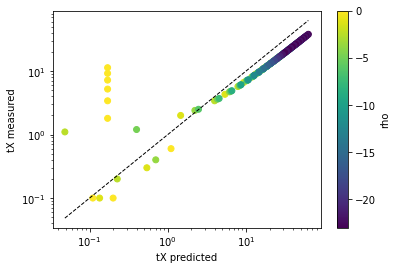

In [99]:
plt.plot([min(tX_preds),max(tX_preds)],[min(tX_preds),max(tX_preds)],linewidth=1,color='black',linestyle='--')
near_1 = np.log(cs)
plt.scatter(tX_preds, tXs, c=near_1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('tX predicted')
hey=plt.ylabel('tX measured')
clb=plt.colorbar()
clb.set_label('c')

Not nearly as pretty as the previous plot when we checked our prediction of `t_start`, and that makes sense; that was a direct and pretty easy calculation, while this formula for `t_NR` was an estimation in certain limits because we got some implicit equation that was impossible to isolate. In particular, the graph gets pretty mess for the lighter dots, which is when $c < 1$, so our approximation has the most error in that limit. Other than that though, I'm pretty happy with the way things look especially for darker (higher) `c` values.